In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
import pickle

# Create custom style dictionary
custom_style = {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0
}

# Update seaborn's whitegrid style with your custom settings
sns.set_theme(style="whitegrid", rc=custom_style)
sns.set_context("paper", 
                font_scale=2.5,
                rc={
                    "lines.linewidth": 2,
                    "axes.grid": True,
                    "grid.alpha": 0.3,
                    "figure.figsize": (8.5, 6)
                })
from matplotlib import rc

rc('xtick.major', pad=10)
rc('ytick.major', pad=10)
rc('grid', linewidth=1.3)

Power-law fitting function

In [2]:
from scipy.optimize import minimize
from itertools import product

def fit_power_law_constant(C, L, num_inits=10, L0=None):
    """
    Fit power law with constant: L = a * C^(-b) + L0
    Uses Huber loss in log-log space for robustness
    
    Args:
        C: Compute values (array)
        L: Loss values (array) 
        num_inits: Number of initializations per parameter
    
    Returns:
        dict with fitted parameters and R^2 score
    """
    def power_law_const(params, x):
        if L0 is None:
            a, b, L0_fit = params
            return a * x**(-b) + L0_fit
        else:
            a, b = params
            return a * x**(-b) + L0
    
    def huber_loss(residual, delta=1e-3):
        mask = np.abs(residual) <= delta
        return np.where(mask, 
                       0.5 * residual**2,
                       delta * (np.abs(residual) - 0.5 * delta))
    
    def objective(params):
        pred = power_law_const(params, C)
        residuals = np.log(pred) - np.log(L)
        return np.mean(huber_loss(residuals))
    
    # Try all combinations of parameter initializations
    best_loss = np.inf
    best_params = None
    
    # Parameter ranges for initialization
    a_range = [0.1, 1]
    b_range = [0.01, 0.3]
    
    # Create evenly spaced initializations for each parameter
    a_inits = np.linspace(a_range[0], a_range[1], num_inits)
    b_inits = np.linspace(b_range[0], b_range[1], num_inits)
    
    if L0 is None:
        L0_range = [min(L)*0.1, min(L)]
        L0_inits = np.linspace(L0_range[0], L0_range[1], num_inits)
        # Try all combinations of a, b, and L0
        for a, b, L0_init in product(a_inits, b_inits, L0_inits):
            init_params = [a, b, L0_init]
            result = minimize(
                objective,
                init_params,
                method='L-BFGS-B',
                bounds=[(0, None), (0, None), (0, None)]  # Changed bounds to >= 0
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_params = result.x
    else:
        # Try all combinations of a and b
        for a, b in product(a_inits, b_inits):
            init_params = [a, b]
            result = minimize(
                objective,
                init_params,
                method='L-BFGS-B',
                bounds=[(0, None), (0, None)]  # Changed bounds to >= 0
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_params = result.x
            
    # Compute R^2 score
    y_pred = power_law_const(best_params, C)
    log_L = np.log(L)
    log_pred = np.log(y_pred)
    ss_res = np.sum((log_L - log_pred) ** 2)
    ss_tot = np.sum((log_L - np.mean(log_L)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    if L0 is None:
        return {
            'a': best_params[0],
            'b': best_params[1],
            'L0': best_params[2],
            'r2': r2
        }
    else:
        return {
            'a': best_params[0],
            'b': best_params[1],
            'L0': L0,
            'r2': r2
        }

Load training logs

In [3]:
options = [
    'mlp', # linear decay schedule
    'c5m', # linear decay schedule
    'chess', # linear decay schedule
    'mlp_const', # constant schedule
    'c5m_const', # constant schedule
    'chess_const', # constant schedule
]

ds_name = options[1]
with open(f'../logs/{ds_name}.pkl', 'rb') as f:
    df = pickle.load(f)
df['D'] = df['D'].astype(int)

In [4]:
# Loss and compute at the compute-optimal point (assumed to be the last training step)
# Already saved in the logs we provided, but need to be computed as follows for any new experiments
if 'opt_L' not in df.columns:
    df['opt_L'] = df.apply(lambda row: row['history']['test_loss'].iloc[-1], axis=1)
if 'opt_C' not in df.columns:
    df['opt_C'] = df.apply(lambda row: row['history']['compute'].iloc[-1], axis=1)

In [5]:
df = df.sort_values("P")

cmap = sns.color_palette("plasma", as_cmap=True)
Pmin = df["P"].min()
Pmax = df["P"].max()
df['color'] = 0.9 * (np.log(df['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))
all_seeds_df = df

Compute expected loss curves

In [6]:
avg_df = []
for P, group in df.groupby('P'):
    # Get list of columns excluding 'history'
    regular_cols = [col for col in group.columns if col != 'history' and col != 'P']
    
    # Create a row for this group
    avg_row = {'P': P}
    
    # Average regular columns
    for col in regular_cols:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(group[col]):
            avg_row[col] = group[col].mean()
        else:
            # Take the first value for non-numeric columns
            avg_row[col] = group[col].iloc[0]
    
    # Handle the 'history' column (which contains dataframes)
    if 'history' in group.columns:
        # Get all history dataframes
        history_dfs = group['history'].tolist()
        
        # Assuming all history dataframes have the same columns
        if history_dfs and all(df is not None for df in history_dfs):
            # Get the first dataframe to determine structure
            first_history = history_dfs[0]
            
            # Create a new dataframe for the averaged history
            
            avg_history = pd.DataFrame(index=first_history.index, columns=first_history.columns)
            # Process each column in the history dataframes
            for col in first_history.columns:
                # Check if this column is numeric across all history dataframes
                if all(pd.api.types.is_numeric_dtype(hist_df[col]) for hist_df in history_dfs):
                    # Average the numeric column
                    col_sum = sum(hist_df[col] for hist_df in history_dfs)
                    avg_history[col] = col_sum / len(history_dfs)
                else:
                    # Take the first value for non-numeric columns
                    avg_history[col] = first_history[col]
            
            avg_row['history'] = avg_history
    
    # Append this row to the list
    avg_df.append(avg_row)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(avg_df)
df['D'] = df['D'].astype(int)

Fit scaling law (need $L_0$ to define normalized curve)

In [ ]:
min_D = 384 if 'mlp' in ds_name else 768
max_D = 4096
max_points = 1000
L0 = None

plot_df = df[(df['D'] >= min_D) & (df['D'] <= max_D) & np.isfinite(df['opt_L'])]
plot_df_seeds = all_seeds_df[(all_seeds_df['D'] >= min_D) & (all_seeds_df['D'] <= max_D) & np.isfinite(all_seeds_df['opt_L'])]
Pmin = plot_df["P"].min()
Pmax = plot_df["P"].max()
plot_df['color'] = 0.9 * (np.log(plot_df['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))
plot_df_seeds['color'] = 0.9 * (np.log(plot_df_seeds['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))

C = plot_df['opt_C'].values
L = plot_df['opt_L'].values

fit_results = fit_power_law_constant(C, L, L0=L0)

# Generate smooth curve for plotting
C_fit = np.logspace(np.log10(0.1 * C.min()), np.log10(10 * C.max()), 100)
def L_fit_fn(C):
    return fit_results['a'] * C**(-fit_results['b']) + fit_results['L0']
L_fit = L_fit_fn(C_fit)

print(f"L = {fit_results['a']:.2f} · C^(-{fit_results['b']:.2f}) + {fit_results['L0']:.2e}")
print(f"R² = {fit_results['r2']:.4f}")

# plt.figure(figsize=(8, 5.75), dpi=100)
plt.figure(figsize=(8, 5.75), dpi=100)
# legend a, b, L0
plt.plot(C_fit, L_fit, '--k', alpha=1, 
            label=r"$L_0 + ac^{{-b}}$", zorder=20)
plt.plot([], [], ' ', label=rf"$a = {fit_results['a']:.3f}$")
plt.plot([], [], ' ', label=rf"$b = {fit_results['b']:.3f}$")
plt.plot([], [], ' ', label=rf"$L_0 = {fit_results['L0']:.3f}$")

# Group seeds by P only
for P_value, seed_group in plot_df_seeds.groupby('P'):
    # Find corresponding mean run
    mean_row = plot_df[plot_df['P'] == P_value]
    
    if len(mean_row) == 0:
        continue
    
    mean_row = mean_row.iloc[0]
    mean_history = mean_row['history']
    
    # Collect all seed losses at each step
    seed_losses = []
    for _, seed_row in seed_group.iterrows():
        seed_losses.append(seed_row['history']['test_loss'].values)
    
    # Calculate mean and 90% CI
    loss_array = np.array(seed_losses)
    loss_mean = np.mean(loss_array, axis=0)
    
    # Calculate 90% confidence interval (5th and 95th percentiles)
    loss_lower = np.percentile(loss_array, 0, axis=0)
    loss_upper = np.percentile(loss_array, 100, axis=0)
    
    # Use compute steps from mean history
    compute_steps = mean_history['compute'].values
    mask = compute_steps <= mean_row['opt_C']
    
    # Plot mean line
    plt.plot(compute_steps[mask], loss_mean[mask], color=cmap(mean_row["color"]), lw=1.5, alpha=0.8)
    
    # Plot shaded 90% CI region
    plt.fill_between(compute_steps[mask], 
                     loss_lower[mask], 
                     loss_upper[mask], 
                     color=cmap(mean_row["color"]), 
                     alpha=0.2)

plt.scatter(C, L, color='red', s=60, zorder=30)
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("Compute (PetaFLOPs)", fontsize=30)
plt.ylabel("Loss", fontsize=30)
C_min = C.min() * 0.3
C_max = C.max() * 3
L_max = L_fit_fn(C_min)
L_min = L_fit_fn(C_max)
plt.xlim(C_min, C_max)
plt.ylim(L_min, L_max)

from matplotlib.ticker import MaxNLocator
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))

plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
# plt.savefig(f"figures/{ds_name}_scaling_law.pdf", bbox_inches='tight')

/tmp/ipykernel_1261534/3181541837.py:33: RuntimeWarning: divide by zero encountered in log
  residuals = np.log(pred) - np.log(L)
/home/shikai_q/miniconda3/envs/super/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [41]:
def add_scaled_metrics(df, L0):
    for i, row in df.iterrows():
        history = row['history']
        opt_L = row['opt_L']
        opt_C = row['opt_C']
        
        history['scaled_L'] = (history['test_loss'] - L0) / (opt_L - L0)
        history['scaled_C'] = history['compute'] / opt_C
        
        df.at[i, 'history'] = history
    
    return df

L0 = fit_results['L0']
plot_df = add_scaled_metrics(plot_df, L0)
plot_df_seeds = add_scaled_metrics(plot_df_seeds, L0)

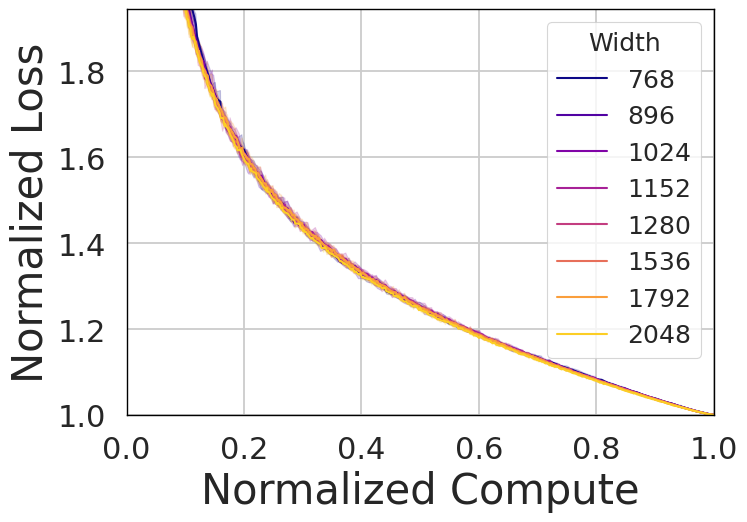

In [42]:
max_points = 1000
plt.figure(figsize=(8, 5.75), dpi=100)

# Plot each mean run with 90% CI from seeds
for i, mean_row in plot_df.iterrows():
    # Find corresponding seeds
    seed_group = plot_df_seeds[plot_df_seeds['P'] == mean_row['P']]
    
    if len(seed_group) > 0:
        # Collect all seed scaled curves
        seed_scaled_C = []
        seed_scaled_L = []
        
        for _, seed_row in seed_group.iterrows():
            # Get seed's rescaled curve
            seed_steps = np.linspace(1, len(seed_row['history']['scaled_C']) - 1, max_points, dtype=int)
            seed_scaled_C.append(seed_row['history']['scaled_C'][seed_steps])
            seed_scaled_L.append(seed_row['history']['scaled_L'][seed_steps])
        
        # Compute mean and CI of scaled curves across seeds
        scaled_C_array = np.array(seed_scaled_C)
        scaled_L_array = np.array(seed_scaled_L)
        
        # Mean of scaled curves
        mean_scaled_C = np.mean(scaled_C_array, axis=0)
        mean_scaled_L = np.mean(scaled_L_array, axis=0)
        
        # 90% CI of scaled_L
        scaled_L_lower = np.percentile(scaled_L_array, 5, axis=0)
        scaled_L_upper = np.percentile(scaled_L_array, 95, axis=0)
        
        # Plot mean line
        plt.plot(mean_scaled_C, mean_scaled_L, color=cmap(mean_row['color']), 
                 lw=1.5, label=f"${mean_row['D']}$")
        
        # Plot shaded 90% CI region
        plt.fill_between(mean_scaled_C, 
                         scaled_L_lower, 
                         scaled_L_upper, 
                         color=cmap(mean_row['color']), 
                         alpha=0.2)
    else:
        # No seeds found, use the mean_row data as fallback
        steps = np.linspace(1, len(mean_row['history']['scaled_C']) - 1, max_points, dtype=int)
        mean_scaled_C = mean_row['history']['scaled_C'][steps]
        mean_scaled_L = mean_row['history']['scaled_L'][steps]
        
        plt.plot(mean_scaled_C, mean_scaled_L, color=cmap(mean_row['color']), 
                 lw=2, label=f"$D={mean_row['D']}$")

plt.xlabel("Normalized Compute", fontsize=30)
plt.ylabel("Normalized Loss", fontsize=30)
plt.xlim(0, 1)

# Find y_max using the largest D run
run = plot_df[plot_df['D'] == plot_df['D'].max()].iloc[0]
y_max = interp1d(run['history']['scaled_C'], run['history']['scaled_L'], bounds_error=False, fill_value=np.inf)(0.1)
plt.ylim(1, y_max)

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), fontsize=18, loc='upper right', title=r"Width")
legend.get_title().set_fontsize(18)

plt.tight_layout()